In [39]:
import pandas as pd
import seaborn as sns
from enum import Enum     # for enum34, or the stdlib version
from pycaret.classification import *
from anonymizeip import anonymize_ip

class AnonTypes(Enum):
    BM = 0 # black marker 
    BI = 1 # bilateral classification
    NO = 2 # no anonymization
    
sample = 0
binary = 1

# anonymization flags
tlp_anonymization = AnonTypes.BI
ip_proto_anonymization = AnonTypes.NO
pkt_counter_anonymization = AnonTypes.NO
oct_counter_anonymization = AnonTypes.NO

In [40]:
from typing import List

def optimize_floats(df: pd.DataFrame) -> pd.DataFrame:
    floats = df.select_dtypes(include=['float64']).columns.tolist()
    df[floats] = df[floats].apply(pd.to_numeric, downcast='float')
    return df


def optimize_ints(df: pd.DataFrame) -> pd.DataFrame:
    ints = df.select_dtypes(include=['int64']).columns.tolist()
    df[ints] = df[ints].apply(pd.to_numeric, downcast='integer')
    return df


def optimize_objects(df: pd.DataFrame, datetime_features: List[str]) -> pd.DataFrame:
    for col in df.select_dtypes(include=['object']):
        if col not in datetime_features:
            if not (type(df[col][0])==list):
                num_unique_values = len(df[col].unique())
                num_total_values = len(df[col])
                if float(num_unique_values) / num_total_values < 0.5:
                    df[col] = df[col].astype('category')
        else:
            df[col] = pd.to_datetime(df[col])
    return df



def optimize(df: pd.DataFrame, datetime_features: List[str] = []):
    return optimize_floats(optimize_ints(optimize_objects(df, datetime_features)))

In [41]:
df = pd.read_csv("../NF-ToN-IoT.csv")

## Checks

In [42]:
df.columns

Index(['IPV4_SRC_ADDR', 'L4_SRC_PORT', 'IPV4_DST_ADDR', 'L4_DST_PORT',
       'PROTOCOL', 'L7_PROTO', 'IN_BYTES', 'OUT_BYTES', 'IN_PKTS', 'OUT_PKTS',
       'TCP_FLAGS', 'FLOW_DURATION_MILLISECONDS', 'Label', 'Attack'],
      dtype='object')

### =================================================================

In [43]:
# Remove non-ipfix standardized features
# See: https://www.ntop.org/guides/nprobe/cli_options.html#netflow-v9-ipfix-format-t
# Thesis: Refer to table 2 for feature names and descriptions

df_ipfix = df[['L4_SRC_PORT', 'L4_DST_PORT', 'PROTOCOL', 'IN_BYTES', 'OUT_BYTES', 'IN_PKTS', 'OUT_PKTS', 'TCP_FLAGS', 'FLOW_DURATION_MILLISECONDS', 'Label', 'Attack']]
#df_ipfix['IPV4_SRC_ADDR'] = df_ipfix['IPV4_SRC_ADDR'].astype('category')
#df_ipfix['IPV4_DST_ADDR'] = df_ipfix['IPV4_DST_ADDR'].astype('category')

df_ipfix = optimize(df_ipfix, [])
df_ipfix.memory_usage()

Index                             128
L4_SRC_PORT                   5517096
L4_DST_PORT                   5517096
PROTOCOL                      1379274
IN_BYTES                      5517096
OUT_BYTES                     5517096
IN_PKTS                       5517096
OUT_PKTS                      5517096
TCP_FLAGS                     2758548
FLOW_DURATION_MILLISECONDS    5517096
Label                         1379274
Attack                        1379654
dtype: int64

In [44]:
df_ipfix.head()

,L4_SRC_PORT,L4_DST_PORT,PROTOCOL,IN_BYTES,OUT_BYTES,IN_PKTS,OUT_PKTS,TCP_FLAGS,FLOW_DURATION_MILLISECONDS,Label,Attack
0,63318,443,6,181,165,2,1,24,327,0,Benign
1,57442,15600,17,63,0,1,0,0,0,0,Benign
2,57452,15600,17,63,0,1,0,0,0,0,Benign
3,138,138,17,472,0,2,0,0,0,0,Benign
4,51989,15600,17,63,0,1,0,0,0,0,Benign


In [45]:
if(binary):
    df_ = df_ipfix.drop("Attack", axis=1)
else:
    df_ = df_ipfix.drop("Label", axis=1)

# Sample data
if(sample):
    df_ = df_.sample(n=50000)

## Feature Anonymization Functions

In [46]:
def anon_tlp(anon_type, df):
    if(anon_type == AnonTypes.BI): # based on - https://datatracker.ietf.org/doc/html/draft-ietf-ipfix-anon#section-4.5.1
        df['L4_SRC_PORT'] = [0 if int(x) <= 1023 else 1 for x in df['L4_SRC_PORT']]
        df['L4_DST_PORT'] = [0 if int(x) <= 1023 else 1 for x in df['L4_DST_PORT']]
    elif(anon_type == AnonTypes.BM):
        df['L4_SRC_PORT'] = 0
        df['L4_DST_PORT'] = 0
 
    return df
    
def anon_pkt_counters(anon_type, df): 
    if(anon_type == AnonTypes.BI): # based on - https://datatracker.ietf.org/doc/html/draft-ietf-ipfix-anon#section-4.4.2
        df['IN_PKTS'] = [0 if int(x) <= 2 else 1 for x in df['IN_PKTS']]
        df['OUT_PKTS'] = [0 if int(x) <= 2 else 1 for x in df['OUT_PKTS']]
    elif(anon_type == AnonTypes.BM): 
        df['IN_PKTS'] = 0
        df['OUT_PKTS'] = 0
    
    return df

def anon_octet_counters(anon_type, df): 
    mean_bytes_in = round(df_['IN_BYTES'].mean()) 
    mean_bytes_out= round(df_['OUT_BYTES'].mean()) 

    if(anon_type == AnonTypes.BI): # based on - https://datatracker.ietf.org/doc/html/draft-ietf-ipfix-anon#section-4.4.2
        df['IN_BYTES'] = [0 if int(x) <= mean_bytes_in else 1 for x in df['IN_BYTES']]
        df['OUT_BYTES'] = [0 if int(x) <= mean_bytes_out else 1 for x in df['OUT_BYTES']]
    elif(anon_type == AnonTypes.BM): 
        df['IN_BYTES'] = 0
        df['OUT_BYTES'] = 0
    
    return df

def anon_ip_proto(anon_type, df):
    grouped_protocols = [1, 6, 17] # 1, 6, and 17 for ICMP, UDP, and TCP 

    if(anon_type == AnonTypes.BI): # based on - https://datatracker.ietf.org/doc/html/draft-ietf-ipfix-anon#section-4.5.1
        df['PROTOCOL'] = [0 if int(x) in grouped_protocols else 1 for x in df['PROTOCOL']] 
    elif(anon_type == AnonTypes.BM): 
        df['PROTOCOL'] = 0
        
    return df

### Anonymization iterations 

In [47]:
#print(df_['L4_SRC_PORT'].value_counts())
df_ = anon_tlp(tlp_anonymization, df_)
df_ = anon_pkt_counters(pkt_counter_anonymization, df_)
df_ = anon_octet_counters(oct_counter_anonymization, df_)
df_ = anon_ip_proto(ip_proto_anonymization, df_)

df_.head()

,L4_SRC_PORT,L4_DST_PORT,PROTOCOL,IN_BYTES,OUT_BYTES,IN_PKTS,OUT_PKTS,TCP_FLAGS,FLOW_DURATION_MILLISECONDS,Label
0,1,0,6,181,165,2,1,24,327,0
1,1,1,17,63,0,1,0,0,0,0
2,1,1,17,63,0,1,0,0,0,0
3,0,0,17,472,0,2,0,0,0,0
4,1,1,17,63,0,1,0,0,0,0


### =================================================================

In [48]:
#df_['ICMP_TYPE'] = df_['ICMP_TYPE'].astype(str)
#df_['ICMP_IPV4_TYPE'] = df_['ICMP_IPV4_TYPE'].astype(str)
categorical = ['L4_SRC_PORT', 'L4_DST_PORT', 'PROTOCOL', 'TCP_FLAGS']

for f in categorical:
    df_[f] = df_[f].astype('str')

#df_ = df_[['TCP_FLAGS', 'FLOW_DURATION_MILLISECONDS', 'Label']]

if(binary):
    session_binary = setup(df_, target = 'Label', experiment_name='binary', categorical_features = categorical, normalize=True)
else:
    session_multi = setup(df_, target = 'Attack', experiment_name='multiclass', categorical_features = categorical, normalize=True)

,Description,Value
0,Session id,2631
1,Target,Label
2,Target type,Binary
3,Original data shape,"(1379274, 10)"
4,Transformed data shape,"(1379274, 14)"
5,Transformed train set shape,"(965491, 14)"
6,Transformed test set shape,"(413783, 14)"
7,Ordinal features,2
8,Numeric features,5
9,Categorical features,4


## Random Forest

In [49]:
rf = create_model('rf')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9474,0.9887,0.9445,0.9896,0.9666,0.8442,0.8493
1,0.9504,0.9881,0.9439,0.9941,0.9684,0.8542,0.8603
2,0.9460,0.9891,0.9430,0.9893,0.9656,0.8402,0.8454
3,0.9476,0.9894,0.9416,0.9929,0.9666,0.8461,0.8525
4,0.9469,0.9895,0.9447,0.9888,0.9662,0.8425,0.8473
5,0.9430,0.9893,0.9434,0.9851,0.9638,0.8304,0.8347
6,0.9427,0.9883,0.9418,0.9863,0.9635,0.8300,0.8348
7,0.9465,0.9885,0.9432,0.9898,0.9659,0.8419,0.8472
8,0.9445,0.9900,0.9445,0.9860,0.9648,0.8348,0.8391


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [50]:
predict_model(rf)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.9999,1.0000,1.0000,0.9999,0.9999,0.9996,0.9996


,L4_SRC_PORT,L4_DST_PORT,PROTOCOL_6,PROTOCOL_17,PROTOCOL_2,PROTOCOL_1,PROTOCOL_58,IN_BYTES,OUT_BYTES,IN_PKTS,OUT_PKTS,TCP_FLAGS,FLOW_DURATION_MILLISECONDS,Label,Label,Score
965491,0.361947,-0.460429,0.319343,-0.310602,-0.065096,-0.015603,-0.009709,-0.005497,-0.007313,-0.004413,-0.004894,0.486290,-0.053116,1,1,1.0
965492,0.361947,-0.460429,0.319343,-0.310602,-0.065096,-0.015603,-0.009709,-0.003551,-0.005901,-0.004050,-0.003795,0.486290,-0.054400,1,1,1.0
965493,0.361947,-0.460429,0.319343,-0.310602,-0.065096,-0.015603,-0.009709,-0.006859,-0.046382,-0.004777,-0.009292,0.464860,-0.029484,1,1,1.0
965494,0.361947,-0.460429,0.319343,-0.310602,-0.065096,-0.015603,-0.009709,-0.007582,-0.046382,-0.005504,-0.009292,0.464860,-0.055240,1,1,1.0
965495,0.361947,-0.460429,0.319343,-0.310602,-0.065096,-0.015603,-0.009709,0.000420,-0.025203,0.004677,0.022590,0.652050,0.030442,1,1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1379269,0.361947,-0.460429,0.319343,-0.310602,-0.065096,-0.015603,-0.009709,-0.007582,-0.046382,-0.005504,-0.009292,0.464860,-0.055223,1,1,1.0
1379270,0.361947,-0.460429,0.319343,-0.310602,-0.065096,-0.015603,-0.009709,-0.001225,0.093491,-0.002595,0.001702,0.584818,-0.052167,1,1,1.0
1379271,-2.762834,2.171887,0.319343,-0.310602,-0.065096,-0.015603,-0.009709,-0.007944,-0.046531,-0.005868,-0.009292,-2.601825,-0.055240,0,0,1.0
1379272,0.361947,-0.460429,0.319343,-0.310602,-0.065096,-0.015603,-0.009709,-0.007582,-0.046382,-0.005504,-0.009292,0.464860,-0.055240,1,1,1.0


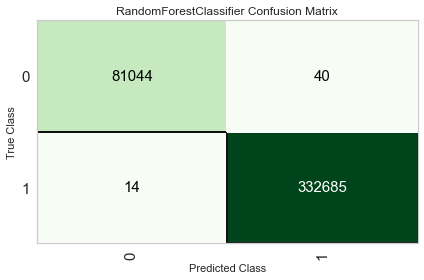

In [51]:
plot_model(rf, plot = 'confusion_matrix', plot_kwargs = {'percent' : False})


## Decision Trees

In [ ]:
dt = create_model('dt') 

In [ ]:
predict_model(dt)

In [ ]:
plot_model(dt, plot = 'confusion_matrix', plot_kwargs = {'percent' : False})

## KNN

In [ ]:
knn = create_model('knn') 

In [ ]:
predict_model(knn)

In [ ]:
plot_model(knn, plot = 'confusion_matrix', plot_kwargs = {'percent' : False})

## SVM

In [ ]:
svm = create_model('svm') 

In [ ]:
predict_model(svm)

In [ ]:
plot_model(svm, plot = 'confusion_matrix', plot_kwargs = {'percent' : False})